##### Define the 1D UNet Model

In [1]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Concatenate
from tensorflow.keras.models import Model

def build_1d_unet(input_shape, num_filters=32, kernel_size=3):
    inputs = Input(shape=input_shape)
    
    # Encoder path
    conv1 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(inputs)
    conv1 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    
    conv2 = Conv1D(num_filters * 2, kernel_size, activation='relu', padding='same')(pool1)
    conv2 = Conv1D(num_filters * 2, kernel_size, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    
    # Bottleneck
    conv3 = Conv1D(num_filters * 4, kernel_size, activation='relu', padding='same')(pool2)
    conv3 = Conv1D(num_filters * 4, kernel_size, activation='relu', padding='same')(conv3)
    
    # Decoder path
    up1 = UpSampling1D(size=2)(conv3)
    up1 = Conv1D(num_filters * 2, kernel_size, activation='relu', padding='same')(up1)
    merge1 = Concatenate()([conv2, up1])
    conv4 = Conv1D(num_filters * 2, kernel_size, activation='relu', padding='same')(merge1)
    conv4 = Conv1D(num_filters * 2, kernel_size, activation='relu', padding='same')(conv4)
    
    up2 = UpSampling1D(size=2)(conv4)
    up2 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(up2)
    merge2 = Concatenate()([conv1, up2])
    conv5 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(merge2)
    conv5 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(conv5)
    
    # Output layer
    outputs = Conv1D(1, kernel_size, activation='linear', padding='same')(conv5)
    
    # Build model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()
    return model


##### Prepare Data

In [2]:
import numpy as np
import pandas as pd

# Load your dataset (assuming CSV files as provided earlier)
X_train = pd.read_csv('Project datasets/Sample files/train_inputs_50.csv', header=None).values
y_train = pd.read_csv('Project datasets/Sample files/train_outputs_50.csv', header=None).values
X_test = pd.read_csv('Project datasets/Sample files/test_inputs_50.csv', header=None).values
y_test = pd.read_csv('Project datasets/Sample files/test_outputs_50.csv', header=None).values

# Expand dimensions to add the channel dimension
X_train = np.expand_dims(X_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

# Verify shapes
print("X_train shape:", X_train.shape)  # Expected: (samples, timesteps, 1)
print("y_train shape:", y_train.shape)  # Expected: (samples, timesteps, 1)
print("X_test shape:", X_test.shape)    # Expected: (samples, timesteps, 1)
print("y_test shape:", y_test.shape)    # Expected: (samples, timesteps, 1)


X_train shape: (50, 500, 1)
y_train shape: (50, 500, 1)
X_test shape: (50, 500, 1)
y_test shape: (50, 500, 1)


##### Train the model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 500, 32)      128         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 500, 32)      3104        ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 250, 32)      0           ['conv1d_1[0][0]']               
                                                                                              

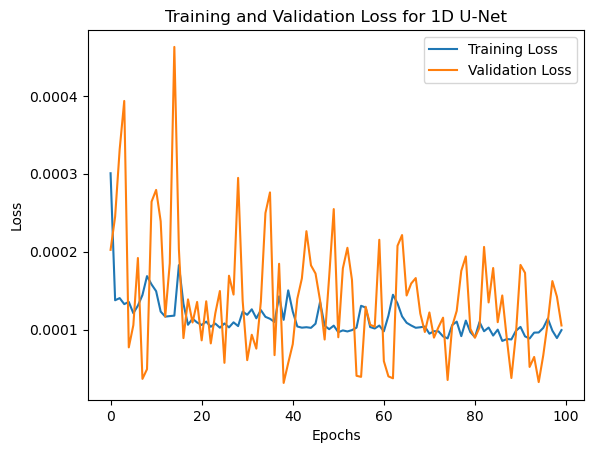

In [4]:
# Define input shape
input_shape = X_train.shape[1:]  # (timesteps, channels)

# Build and compile the U-Net model
unet_model = build_1d_unet(input_shape, num_filters=32, kernel_size=3)

# Train the model
history = unet_model.fit(X_train, y_train, epochs=100, batch_size=4, validation_data=(X_test, y_test))

# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss for 1D U-Net')
plt.show()


##### Visualize Denoised vs Clean Spectra

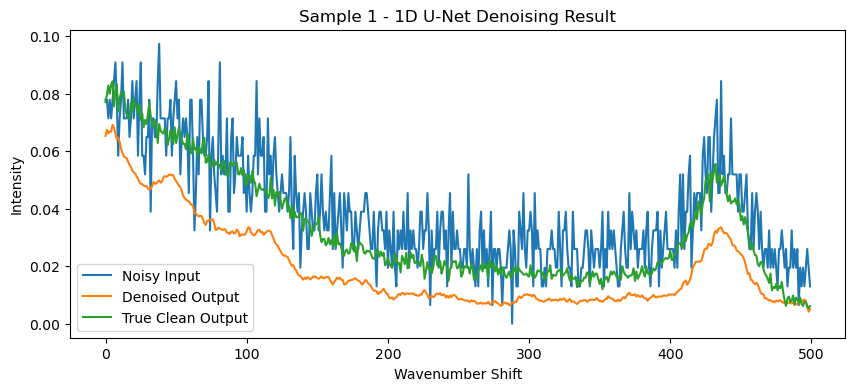

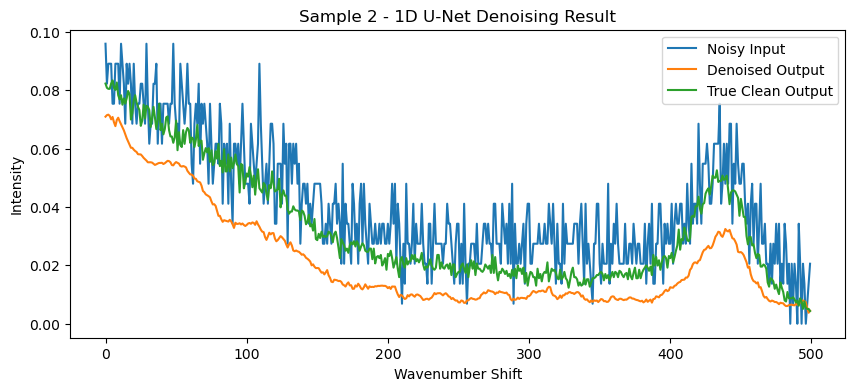

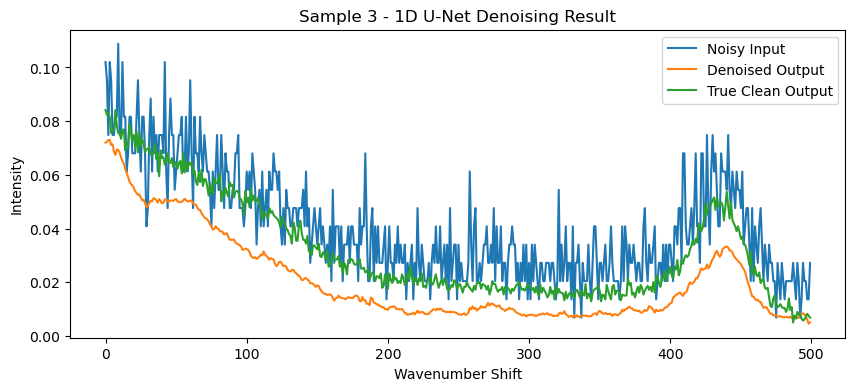

In [6]:
for i in range(3):  # Plot a few examples
    plt.figure(figsize=(10, 4))
    plt.plot(X_test[i].flatten(), label='Noisy Input')
    plt.plot(predicted_output[i].flatten(), label='Denoised Output')
    plt.plot(y_test[i].flatten(), label='True Clean Output')
    plt.xlabel('Wavenumber Shift')
    plt.ylabel('Intensity')
    plt.legend()
    plt.title(f'Sample {i+1} - 1D U-Net Denoising Result')
    plt.show()


##### Evaluate the model

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skimage.metrics import structural_similarity as ssim

# Predict on the test set
predicted_output = unet_model.predict(X_test)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test.flatten(), predicted_output.flatten()))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# MAE
mae = mean_absolute_error(y_test.flatten(), predicted_output.flatten())
print(f"Mean Absolute Error (MAE): {mae}")

# SNR
signal_power = np.sum(y_test ** 2)
noise_power = np.sum((y_test - predicted_output) ** 2)
snr = 10 * np.log10(signal_power / noise_power)
print(f"Signal-to-Noise Ratio (SNR): {snr} dB")

# PSNR
peak_signal = np.max(y_test)
psnr = 10 * np.log10((peak_signal ** 2) / mean_squared_error(y_test.flatten(), predicted_output.flatten()))
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr} dB")

# SSIM (Mean Structural Similarity Index)
ssim_values = [ssim(y_test[i].flatten(), predicted_output[i].flatten()) for i in range(len(y_test))]
mean_ssim = np.mean(ssim_values)
print(f"Mean Structural Similarity Index (SSIM): {mean_ssim}")

2/2 [==============================] - 1s 56ms/step
Root Mean Squared Error (RMSE): 0.01026457756696739
Mean Absolute Error (MAE): 0.009015051408874914
Signal-to-Noise Ratio (SNR): 11.7513224835455 dB
Peak Signal-to-Noise Ratio (PSNR): 19.005776080147843 dB
Mean Structural Similarity Index (SSIM): 0.9458616857856254


c:\Users\91892\anaconda3\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)
